HighTime - Web traffic analysis neural model
=============
<span style="color: lightsteelblue;">Deep Learning</span>

The goal of this assignment is to train a simple DNN model to make predictions over web traffic.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import matplotlib.pyplot as plt

Let us mimic real traffic data by using normal distribution:

[  9  18  21  46  96 150 187 280 331 387 470 505 487 462 430 341 268 184]


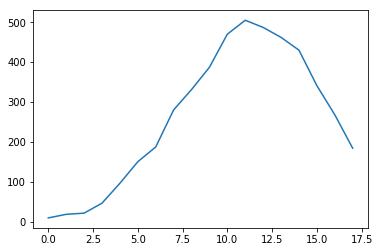

In [2]:
def fake_train(batch_size=24):
  assert batch_size > 0 and batch_size < 25
  normal = np.random.normal(12, 4, 5000)
  train = np.arange(batch_size)

  for i in range(0, batch_size):
    count = 0
    for p in normal:
      if (p >= i and p < i + 1):
        count += 1
    train[i] = count
  return train

example = fake_train(18)
print(example)

plt.plot(range(0, 18), example)
plt.show()

Function to generate a training batch:

In [101]:
total_seconds = 24 * 3600
total_rps = 1000

def secs_to_time(time_in_seconds):
  hours = time_in_seconds // 3600
  minutes = (time_in_seconds - hours * 3600) // 60
  seconds = time_in_seconds - hours * 3600 - minutes * 60
  return hours, minutes, seconds

def time_to_secs(hour, minutes, seconds):
  return hour * 3600 + minutes * 60 + seconds

def time_to_squashed_secs(hour, minutes, seconds):
  return time_to_secs(hour, minutes, seconds) / total_seconds

def secs_to_string(sec):
  result = ':'.join([('%d' % i) for i in secs_to_time(sec)])
  return result + (' (%dth second)' % sec)

def squashed_secs_to_string(sq_sec):
  return secs_to_string(sq_sec * total_seconds)

def squashed_label_to_label(sq_label):
  return sq_label * total_rps

class BatchGenerator(object):
  def __init__(self, batch_size):
    self._batch_size = batch_size

  def spit(self):
    labels = fake_train(self._batch_size).reshape(self._batch_size, 1)
    train = []

    for hour in range(self._batch_size):
      minutes = random.randint(0, 59)
      seconds = random.randint(0, 59)
      train.append(time_to_squashed_secs(hour, minutes, seconds))

    return np.array(train, dtype=np.float32).reshape(self._batch_size, 1), (labels / total_rps)

Generate valid and test datasets:

In [102]:
generator = BatchGenerator(24)

test_dataset, test_labels = generator.spit()

# print(test_dataset)
# print(test_labels)

for sec, label in list(zip(test_dataset, test_labels)):
  print('Time %s => %03.2f rps' % (squashed_secs_to_string(sec), squashed_label_to_label(label)))

Time 0:58:41 (3521th second) => 9.00 rps
Time 1:54:17 (6857th second) => 13.00 rps
Time 2:18:15 (8295th second) => 27.00 rps
Time 3:25:14 (12314th second) => 60.00 rps
Time 4:56:33 (17793th second) => 86.00 rps
Time 5:53:24 (21204th second) => 109.00 rps
Time 6:17:42 (22662th second) => 175.00 rps
Time 7:0:2 (25202th second) => 291.00 rps
Time 8:43:29 (31409th second) => 332.00 rps
Time 9:24:17 (33857th second) => 413.00 rps
Time 10:22:57 (37377th second) => 497.00 rps
Time 11:52:25 (42745th second) => 439.00 rps
Time 12:16:42 (44202th second) => 495.00 rps
Time 13:28:47 (48527th second) => 513.00 rps
Time 14:11:29 (51089th second) => 385.00 rps
Time 15:30:42 (55842th second) => 346.00 rps
Time 16:11:37 (58297th second) => 268.00 rps
Time 17:6:47 (61607th second) => 186.00 rps
Time 18:22:31 (66151th second) => 138.00 rps
Time 19:53:54 (71634th second) => 96.00 rps
Time 20:32:24 (73944th second) => 56.00 rps
Time 21:58:10 (79090th second) => 28.00 rps
Time 22:58:50 (82730th second) => 1

Simple NN Model with one hidden layer and hyperbolic tangent activation function.

In [161]:
feature_size = 1 # number of features to feed input
num_labels = 1 # number of output labels
num_hidden_nodes = 2
batch_size = 24
learning_rate = 0.05

graph = tf.Graph()
with graph.as_default():
  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  X = tf.placeholder(tf.float32, shape=(batch_size, feature_size))
  Y = tf.placeholder(tf.float32, shape=(batch_size, 1))

  tf_test_dataset = tf.constant(test_dataset)
  predict_data = tf.placeholder(tf.float32, shape=(1, feature_size))

  # Hidden layer variables
  weights1 = tf.Variable(tf.ones([feature_size, num_hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))

  # Variables.
  weights2 = tf.Variable(tf.ones([num_hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
  o = tf.matmul(X, weights1) + biases1
  hidden_layer = tf.tan(o)

  y = tf.matmul(hidden_layer, weights2) + biases2
  error = y - Y
  sq_error = tf.square(error)
  loss = tf.reduce_mean(sq_error)

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

  # Predictions for the training, test and real data.
#   train_prediction = y
#   test_prediction_hidden = tf.nn.sigmoid(tf.matmul(tf_test_dataset, weights1) + biases1)
#   test_prediction = tf.matmul(test_prediction_hidden, weights2) + biases2
  prediction_hidden = tf.tan(tf.matmul(predict_data, weights1) + biases1)
  prediction = tf.matmul(prediction_hidden, weights2) + biases2

In [79]:
a = np.array([0.759, 0.371, 0.2378, -0.1861], np.float32)
print(a)

sigma = tf.nn.sigmoid(a).eval(session=tf.Session())
print(sigma)

[ 0.759  0.371  0.238 -0.186]
[ 0.681  0.592  0.559  0.454]


In [163]:
num_steps = 311
generator = BatchGenerator(batch_size)

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels))
          / predictions.shape[0])

session = tf.Session(graph=graph)

with graph.as_default():
  with session.as_default():
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
      batch_data, batch_labels = generator.spit()
      feed_dict = {X : batch_data, Y : batch_labels}
      _, l, w2e = session.run(
        [optimizer, loss, weights2], feed_dict=feed_dict)
      if (step % 10 == 0):
        print("Minibatch loss at step %d: %f" % (step, l))
#         print("output: %s" % (oe))
#         print("hidden layer %s" % (hl))
#         print("X: %s" % (Xe))
#         print("Y: %s" % (Ye))
#         print("w1: %s" % (w1e))
#         print("bias1: %s" % (b1e))
#         print("y: %s" % (ye))
        print("w2: %s" % (w2e))
#         print("bias2: %s" % (b2e))
#         print("error: %s" % (ee))
#         print("squared error: %s" % (see))

  #         print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
    #       print("Validation accuracy: %.1f%%" % accuracy(
    #         valid_prediction.eval(), valid_labels))
  #         print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 1.806150
w2: [[ 0.902]
 [ 0.902]]
Minibatch loss at step 10: 0.168694
w2: [[ 0.808]
 [ 0.808]]
Minibatch loss at step 20: 0.122918
w2: [[ 0.749]
 [ 0.749]]
Minibatch loss at step 30: 0.093781
w2: [[ 0.703]
 [ 0.703]]
Minibatch loss at step 40: 0.080726
w2: [[ 0.667]
 [ 0.667]]
Minibatch loss at step 50: 0.070243
w2: [[ 0.637]
 [ 0.637]]
Minibatch loss at step 60: 0.060039
w2: [[ 0.613]
 [ 0.613]]
Minibatch loss at step 70: 0.055923
w2: [[ 0.591]
 [ 0.591]]
Minibatch loss at step 80: 0.054337
w2: [[ 0.573]
 [ 0.573]]
Minibatch loss at step 90: 0.047169
w2: [[ 0.557]
 [ 0.557]]
Minibatch loss at step 100: 0.045073
w2: [[ 0.543]
 [ 0.543]]
Minibatch loss at step 110: 0.042375
w2: [[ 0.530]
 [ 0.530]]
Minibatch loss at step 120: 0.042189
w2: [[ 0.519]
 [ 0.519]]
Minibatch loss at step 130: 0.039572
w2: [[ 0.509]
 [ 0.509]]
Minibatch loss at step 140: 0.038591
w2: [[ 0.500]
 [ 0.500]]
Minibatch loss at step 150: 0.036589
w2: [[ 0.491]
 [ 0.491]]
Minibat

In [168]:
to_predict = time_to_squashed_secs(1, 0, 0)
print('We want to predict rps at %s' % squashed_secs_to_string(to_predict))
data_to_predict = np.array([to_predict]).reshape(1, feature_size)

with session.as_default():
  predicted = prediction.eval(feed_dict={predict_data : data_to_predict})
  print(squashed_label_to_label(predicted))
#   print(weights1.eval())
#   print(biases1.eval())

We want to predict rps at 1:0:0 (3600th second)
[[ 134.804]]


In [112]:
num_steps = 31
generator = BatchGenerator(24)

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels))
          / predictions.shape[0])

session = tf.Session(graph=graph)

with graph.as_default():
  with session.as_default():
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
      for batch in np.array(generator.spit()).reshape(2, 24).T:
#         np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
#         print(batch)

        batch_data, batch_labels = np.array(batch).reshape(2, 1, 1)
  #       batch_data, batch_labels = generator.spit()

#         print(batch.reshape(2, 24))
#         print(batch_data.shape, batch_labels.shape)
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {X : batch_data, Y : batch_labels}
        _, l = session.run(
          [optimizer, loss], feed_dict=feed_dict)
      if (step % 10 == 0):
        print("Minibatch loss at step %d: %f" % (step, l))
#         print("output: %s" % (oe))
#         print("hidden layer %s" % (hl))
#         print("X: %s" % (Xe))
#         print("Y: %s" % (Ye))
#         print("w1: %s" % (w1e))
#         print("bias1: %s" % (b1e))
#         print("y: %s" % (ye))
#         print("w2: %s" % (w2e))
#         print("bias2: %s" % (b2e))
#         print("error: %s" % (ee))
#         print("squared error: %s" % (see))

  #         print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
    #       print("Validation accuracy: %.1f%%" % accuracy(
    #         valid_prediction.eval(), valid_labels))
  #         print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 0.003011
Minibatch loss at step 10: 0.002587
Minibatch loss at step 20: 0.002387
Minibatch loss at step 30: 0.003445


Let us check it out

In [117]:
to_predict = time_to_squashed_secs(1, 0, 0)
print('We want to predict rps at %s' % squashed_secs_to_string(to_predict))
data_to_predict = np.array([to_predict]).reshape(1, feature_size)

with session.as_default():
  predicted = prediction.eval(feed_dict={predict_data : data_to_predict})
  print(squashed_label_to_label(predicted))
#   print(weights1.eval())
#   print(biases1.eval())

We want to predict rps at 1:0:0 (3600th second)
[[ 336.656]]
